### Running the GUI

We'll first try to run the LifeSim GUI and produce a catalogue.

In [1]:
from lifesim import Gui

In [2]:
Gui()

libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


I had some trouble getting the GUI to show because of some missing QT dependencies (as did some classmates) but I)We had some trouble but turns out you need to load the spectra in the program first. 

In [3]:
import lifesim
import requests

In [4]:
bus = lifesim.Bus()

In [5]:
bus.data.options.set_scenario('baseline')

In [6]:
bus.data.options.set_manual(diameter=4.)
bus.data.options.set_manual(output_path='/home/sshamsi/Projects/astrobio_tutorials/t1_lifesim/')
bus.data.options.set_manual(output_filename='tutorial_poutput')

In [7]:
### We will download the following population file to process it 
# data = requests.get('https://raw.githubusercontent.com/kammerje/P-pop/main/TestPlanetPopulation.txt')

# We will create a file called ppop_catalog.txt and write processed data onto it
catalog_path = '/home/sshamsi/Projects/astrobio_tutorials/t1_lifesim/ppop_catalog.txt'
# with open(catalog_path, 'wb') as file:
#     file.write(data.content)

In [8]:
# ---------- Loading the Catalog ----------

bus.data.catalog_from_ppop(input_path=catalog_path)
bus.data.catalog_remove_distance(stype='A', mode='larger', dist=0.)  # remove all A stars
bus.data.catalog_remove_distance(stype='M', mode='larger', dist=10.)  # remove M stars > 10pc to

Processed line 45884 of 45884


In [9]:
# create modules and add to bus
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)
local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)
star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# connect all modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))

bus.connect(('star', 'transm'))

In [10]:
# ---------- Creating the Optimizer ----------
# After every planet is given an SNR, we want to distribute the time available in the search phase
# such that we maximize the number of detections.

# optimizing the result
opt = lifesim.Optimizer(name='opt')
bus.add_module(opt)
ahgs = lifesim.AhgsModule(name='ahgs')
bus.add_module(ahgs)

bus.connect(('transm', 'opt'))
bus.connect(('inst', 'opt'))
bus.connect(('opt', 'ahgs'))

In [11]:
# ---------- Running the Simulation ----------

# run simulation. This function assigns every planet an SNR for 1 hour of integration time. Since
# we are currently only simulating photon noise, the SNR will scale with the integration time as
# sqrt(t)
instrument.get_snr()

opt.ahgs()

100%|████████████████████████████████████| 535/535 [02:23<00:00,  3.73it/s]


Number of planets detected by stellar type:
A: 0.0  F: 1.7  G: 5.8  K: 35.4  M: 38.3  -  (2.0 / 2.0) yrs observed


In [12]:
# ---------- Saving the Results ----------

bus.save()

Saving database and config files...
Catalog saved
[Done]


In [13]:
bus.data.catalog.to_csv('/home/sshamsi/Projects/astrobio_tutorials/t1_lifesim/poutput.csv')

In [14]:
# ---------- Reading the Results ----------
# import a previously saved catalog
# bus_read = lifesim.Bus()
# bus_read.build_from_config('/home/sshamsi/Projects/t1_lifesim/tuorial_planetary_output.yaml')
# bus_read.data.import_catalog(input_path='/home/sshamsi/Projects/t1_lifesim/tuorial_planetary_output_catalog.hdf5')

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')

In [16]:
df = pd.read_csv('foo.csv')
df

,Unnamed: 0,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,0,2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,...,0.745910,1.746354,1.246132,False,3.747645,21.85221,True,11.808785,35743.408285,0.0
1,1,1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,...,0.745910,1.746354,1.246132,False,2.570891,21.85221,True,8.100845,35743.408285,0.0
2,2,0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,...,0.745910,1.746354,1.246132,True,0.051327,21.85221,False,0.161731,35743.408285,0.0
3,3,1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,...,0.745910,1.746354,1.246132,False,8.482665,21.85221,True,26.728775,35743.408285,0.0
4,4,2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,...,0.745910,1.746354,1.246132,False,7.213424,21.85221,True,22.729412,35743.408285,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,13999,0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,...,0.057153,0.151491,0.104322,True,0.286335,100.00000,False,0.000000,0.000000,-36000.0
14000,14000,0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,...,0.057153,0.151491,0.104322,False,1.669327,100.00000,False,0.000000,0.000000,-36000.0
14001,14001,1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,...,0.057153,0.151491,0.104322,True,0.552908,100.00000,False,0.000000,0.000000,-36000.0
14002,14002,1.31487,184.70674,1.57873,0.0,2.15206,4.52980,5.85123,2.65320,0.54567,...,0.057153,0.151491,0.104322,False,0.024031,100.00000,False,0.000000,0.000000,-36000.0


In [17]:
df_notfloat = df.columns[(df.dtypes.values != np.dtype('float64'))]

for i in range(len(df_notfloat)):
    df[df_notfloat[i]] = df[df_notfloat[i]].astype('category').cat.codes

In [18]:
df = df.drop(df.columns[0], axis=1)
df = df.drop(labels=['ecc_p', 'name_s'], axis=1)

df

,radius_p,p_orb,mass_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,2.55899,1.21237,6.46922,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,0.07928,...,0.745910,1.746354,1.246132,0,3.747645,21.85221,1,11.808785,35743.408285,0.0
1,1.62557,95.32925,2.94136,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,0.06438,...,0.745910,1.746354,1.246132,0,2.570891,21.85221,1,8.100845,35743.408285,0.0
2,0.64641,413.44526,0.18259,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,0.01797,...,0.745910,1.746354,1.246132,1,0.051327,21.85221,0,0.161731,35743.408285,0.0
3,1.45874,51.20469,5.36760,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,0.09864,...,0.745910,1.746354,1.246132,0,8.482665,21.85221,1,26.728775,35743.408285,0.0
4,2.03712,98.57858,4.45356,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,0.05960,...,0.745910,1.746354,1.246132,0,7.213424,21.85221,1,22.729412,35743.408285,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0.82089,48.64809,3.00300,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,0.07304,...,0.057153,0.151491,0.104322,1,0.286335,100.00000,0,0.000000,0.000000,-36000.0
14000,0.76631,3.78368,0.47407,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,0.00894,...,0.057153,0.151491,0.104322,0,1.669327,100.00000,0,0.000000,0.000000,-36000.0
14001,1.29841,30.83798,1.36537,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,0.09392,...,0.057153,0.151491,0.104322,1,0.552908,100.00000,0,0.000000,0.000000,-36000.0
14002,1.31487,184.70674,1.57873,2.15206,4.52980,5.85123,2.65320,0.54567,0.19618,0.09322,...,0.057153,0.151491,0.104322,0,0.024031,100.00000,0,0.000000,0.000000,-36000.0


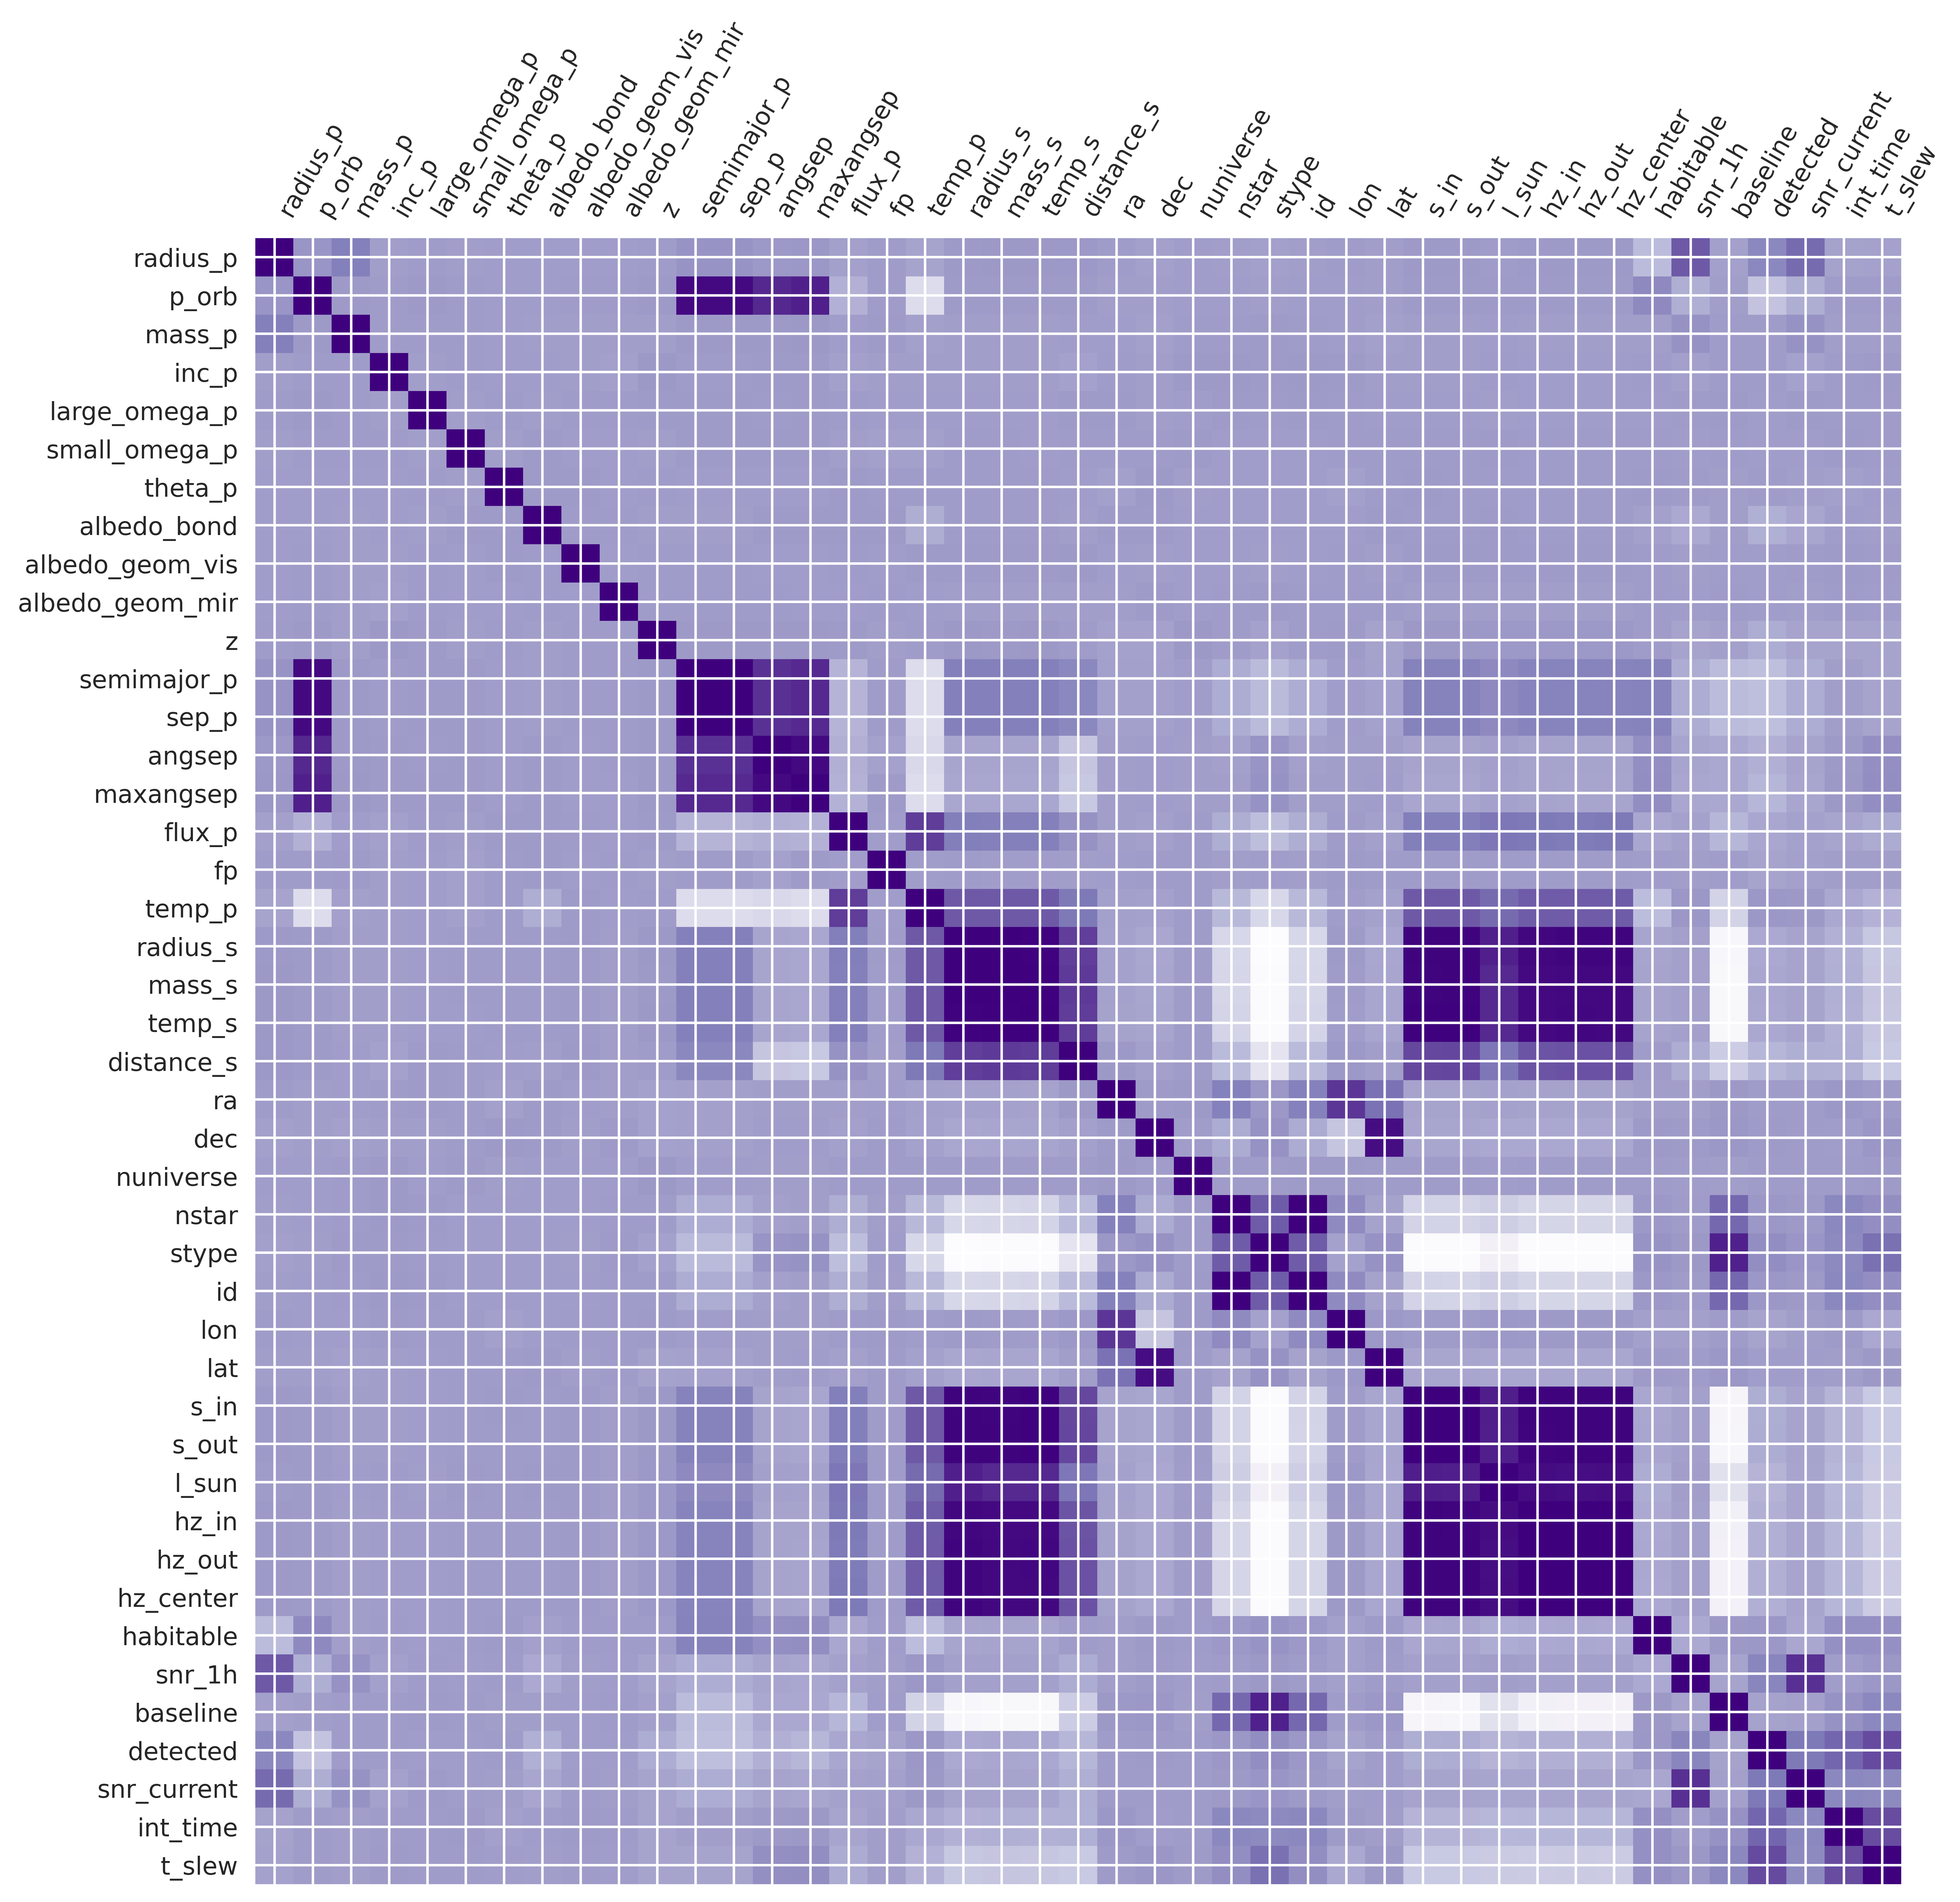

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=600)

ax.matshow(df.corr(), cmap='Purples')

ax.set_xticks(list(range(len(df.columns))))
ax.set_yticks(list(range(len(df.columns))))

ax.set_xticklabels(labels=list(df.columns))
ax.set_yticklabels(labels=list(df.columns))

plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='left', fontsize='medium')

plt.savefig('/home/sshamsi/Projects/astrobio_tutorials/t1_lifesim/corr_matrix.png', dpi=600)